In [22]:
# ==========================================================
# Clinical Trial EDA + ML Modeling
# ==========================================================

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [23]:
# Step 2: Load Dataset
file_path = "clinical_trial_dataset.csv"
df = pd.read_csv(file_path)

print("✅ Dataset Loaded Successfully")
print("Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())

✅ Dataset Loaded Successfully
Shape: (20000, 16)

Column Names:
 ['Patient_ID', 'Age', 'Outliesr', 'Gender', 'City', 'Medical_History', 'Risk_Factors', 'Screening_Date', 'Eligibility_Status', 'Reason_For_Ineligibility', 'Recruitment_Status', 'Recruitment_Date', 'Adherence_Score', 'Last_Checkin_Date', 'Adverse_Events', 'Followup_Schedule']


In [24]:
# Step 3: Basic Overview
display(df.head())
df.info()
print("\nMissing Values:\n", df.isnull().sum())

,Patient_ID,Age,Outliesr,Gender,City,Medical_History,Risk_Factors,Screening_Date,Eligibility_Status,Reason_For_Ineligibility,Recruitment_Status,Recruitment_Date,Adherence_Score,Last_Checkin_Date,Adverse_Events,Followup_Schedule
0,P00001,65,1.530165,Male,Lake Eric,Diabetes,Smoker,25-03-2024,Eligible,Severe Asthma,Pending Screening,27-09-2024,71,06-07-2025,Mild headache,23-09-2025
1,P00002,49,-0.006907,Male,Lake Eric,NaN,Obese,13-09-2024,Not Eligible,High BP,Pending Screening,27-09-2024,75,04-08-2025,Nausea,24-09-2025
2,P00003,49,-0.006907,Male,Dorseybury,NaN,Smoker,13-09-2024,Eligible,Other Conditions,Dropped Out,27-09-2024,75,04-08-2025,Nausea,24-09-2025
3,P00004,49,-0.006907,Male,Lake Eric,Asthma,Smoker,11-06-2024,Eligible,High BP,Recruited,27-09-2024,75,04-08-2025,Nausea,24-09-2025
4,P00005,49,-0.006907,Female,Delgadoburgh,Heart Disease,Smoker,13-09-2024,Eligible,High BP,Dropped Out,27-09-2024,93,02-07-2025,Mild headache,24-09-2025


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient_ID                20000 non-null  object 
 1   Age                       20000 non-null  int64  
 2   Outliesr                  20000 non-null  float64
 3   Gender                    20000 non-null  object 
 4   City                      20000 non-null  object 
 5   Medical_History           17139 non-null  object 
 6   Risk_Factors              16607 non-null  object 
 7   Screening_Date            20000 non-null  object 
 8   Eligibility_Status        20000 non-null  object 
 9   Reason_For_Ineligibility  16664 non-null  object 
 10  Recruitment_Status        20000 non-null  object 
 11  Recruitment_Date          20000 non-null  object 
 12  Adherence_Score           20000 non-null  int64  
 13  Last_Checkin_Date         20000 non-null  object 
 14  Advers

In [25]:
# ==========================================================
# Step 4: Data Cleaning
# ==========================================================

# Remove duplicates
df = df.drop_duplicates()

# Fix obvious data issues (Outliesr → Outliers)
if 'Outliesr' in df.columns:
    df.rename(columns={'Outliesr': 'Outliers'}, inplace=True)

# Convert date columns
for col in ['Screening_Date', 'Recruitment_Date', 'Last_Checkin_Date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing Adherence_Score by filling mean
if 'Adherence_Score' in df.columns:
    df['Adherence_Score'] = df['Adherence_Score'].fillna(df['Adherence_Score'].mean())

In [26]:
# ==========================================================
# Step 5: EDA
# ==========================================================

print("\nBasic Statistics:")
display(df.describe(include='all'))


Basic Statistics:


,Patient_ID,Age,Outliers,Gender,City,Medical_History,Risk_Factors,Screening_Date,Eligibility_Status,Reason_For_Ineligibility,Recruitment_Status,Recruitment_Date,Adherence_Score,Last_Checkin_Date,Adverse_Events,Followup_Schedule
count,20000,20000.000000,2.000000e+04,20000,20000,17139,16607,20000,20000,16664,20000,20000,20000.000000,16506,17144,20000
unique,20000,NaN,NaN,2,5541,4,3,NaN,2,3,4,NaN,NaN,NaN,4,31
top,P00001,NaN,NaN,Male,Lake Eric,Heart Disease,Smoker,NaN,Eligible,High BP,Pending Screening,NaN,NaN,NaN,Dizziness,24-09-2025
freq,1,NaN,NaN,15103,13296,8550,10015,NaN,15065,10168,10075,NaN,NaN,NaN,8670,13527
mean,NaN,49.071900,2.715500e-10,NaN,NaN,NaN,NaN,2024-09-13 02:41:34.080000,NaN,NaN,NaN,2024-09-27 07:48:56.160000,74.961300,2025-04-19 14:58:19.236641024,NaN,NaN
min,NaN,18.000000,-2.984986e+00,NaN,NaN,NaN,NaN,2024-01-01 00:00:00,NaN,NaN,NaN,2024-01-01 00:00:00,50.000000,2025-01-07 00:00:00,NaN,NaN
25%,NaN,49.000000,-6.907220e-03,NaN,NaN,NaN,NaN,2024-09-13 00:00:00,NaN,NaN,NaN,2024-09-27 00:00:00,75.000000,2025-04-08 00:00:00,NaN,NaN
50%,NaN,49.000000,-6.907220e-03,NaN,NaN,NaN,NaN,2024-09-13 00:00:00,NaN,NaN,NaN,2024-09-27 00:00:00,75.000000,2025-04-08 00:00:00,NaN,NaN
75%,NaN,49.000000,-6.907220e-03,NaN,NaN,NaN,NaN,2024-09-13 00:00:00,NaN,NaN,NaN,2024-09-27 00:00:00,75.000000,2025-04-08 00:00:00,NaN,NaN
max,NaN,80.000000,2.971171e+00,NaN,NaN,NaN,NaN,2025-06-01 00:00:00,NaN,NaN,NaN,2025-07-01 00:00:00,100.000000,2025-12-08 00:00:00,NaN,NaN


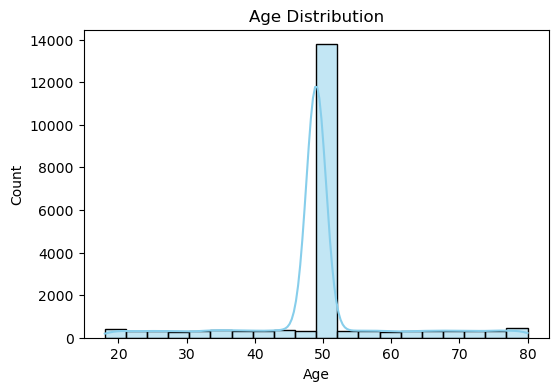

In [27]:
# --- Age Distribution ---
plt.figure(figsize=(6,4))
sns.histplot(df['Age'], kde=True, bins=20, color='skyblue')
plt.title("Age Distribution")
plt.show()

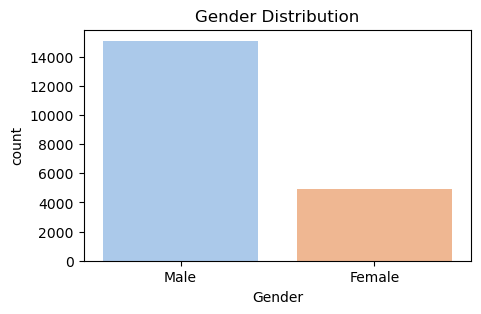

In [28]:
# --- Gender Distribution ---
plt.figure(figsize=(5,3))
sns.countplot(x='Gender', data=df, palette='pastel')
plt.title("Gender Distribution")
plt.show()

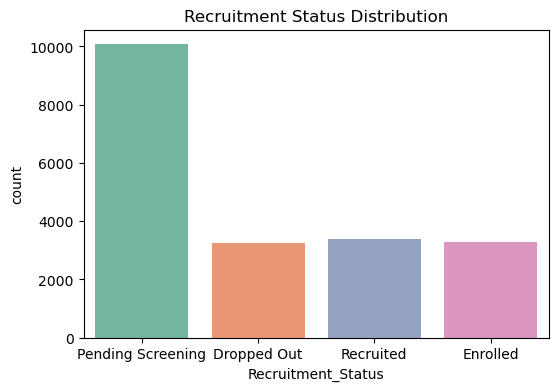

In [29]:
# --- Recruitment Status ---
plt.figure(figsize=(6,4))
sns.countplot(x='Recruitment_Status', data=df, palette='Set2')
plt.title("Recruitment Status Distribution")
plt.show()

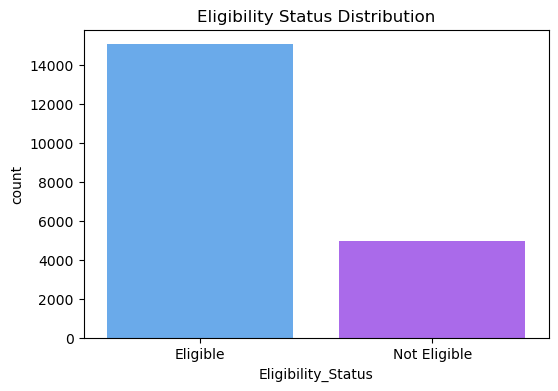

In [30]:
# --- Eligibility Status ---
plt.figure(figsize=(6,4))
sns.countplot(x='Eligibility_Status', data=df, palette='cool')
plt.title("Eligibility Status Distribution")
plt.show()

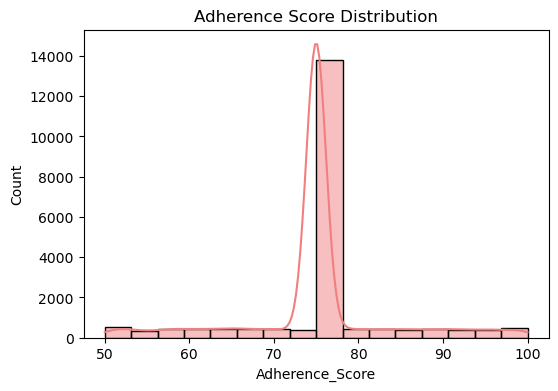

In [31]:
# --- Adherence Score Distribution ---
plt.figure(figsize=(6,4))
sns.histplot(df['Adherence_Score'], kde=True, color='lightcoral')
plt.title("Adherence Score Distribution")
plt.show()

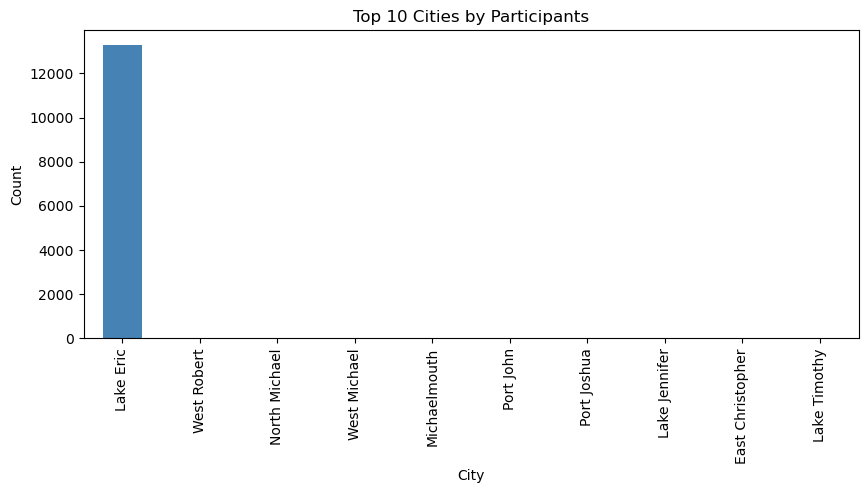

In [32]:
# --- City-wise Recruitment ---
if 'City' in df.columns:
    plt.figure(figsize=(10,4))
    df['City'].value_counts().head(10).plot(kind='bar', color='steelblue')
    plt.title("Top 10 Cities by Participants")
    plt.xlabel("City")
    plt.ylabel("Count")
    plt.show()

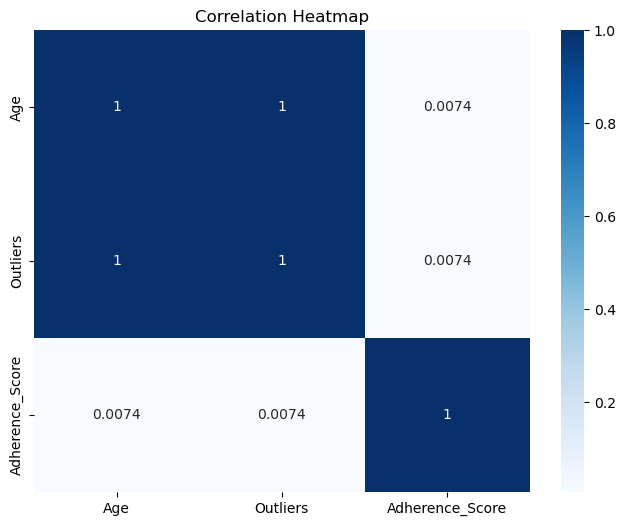

In [33]:
# --- Correlation Heatmap ---
num_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

In [34]:
# ==========================================================
# Step 6: Feature Engineering for ML
# ==========================================================

# Define dropout risk label (1 = likely dropout, 0 = adherent)
# We'll assume patients with Adherence_Score < 60 or Adverse_Events = 'Yes' are at risk.
df['Dropout_Risk'] = np.where(
    ((df['Adherence_Score'] < 60) | (df['Adverse_Events'].astype(str).str.lower() == 'yes')),
    1, 0
)

print("\nDropout Risk Value Counts:")
print(df['Dropout_Risk'].value_counts())


Dropout Risk Value Counts:
Dropout_Risk
0    18730
1     1270
Name: count, dtype: int64


In [35]:
# ==========================================================
# Step 7: Select Features for Modeling
# ==========================================================

features = ['Age', 'Gender', 'City', 'Medical_History', 'Risk_Factors',
            'Eligibility_Status', 'Recruitment_Status', 'Adherence_Score']

X = df[features]
y = df['Dropout_Risk']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining Samples:", X_train.shape[0], "| Test Samples:", X_test.shape[0])



Training Samples: 16000 | Test Samples: 4000


In [36]:
# ==========================================================
# Step 8: Preprocessing Pipelines
# ==========================================================

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [37]:
# ==========================================================
# Step 9: Model 1 - Logistic Regression
# ==========================================================
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("\n🔹 Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_lr))


🔹 Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3746
           1       0.89      1.00      0.94       254

    accuracy                           0.99      4000
   macro avg       0.94      1.00      0.97      4000
weighted avg       0.99      0.99      0.99      4000

ROC-AUC Score: 0.9957287773625201


In [38]:
# ==========================================================
# Step 10: Model 2 - Random Forest
# ==========================================================
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n🔹 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf))


🔹 Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3746
           1       1.00      1.00      1.00       254

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

ROC-AUC Score: 1.0


In [39]:
# ==========================================================
# Step 11: Model 3 - XGBoost
# ==========================================================
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=5,
        eval_metric='logloss', random_state=42))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n🔹 XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))


🔹 XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3746
           1       1.00      1.00      1.00       254

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

ROC-AUC Score: 1.0


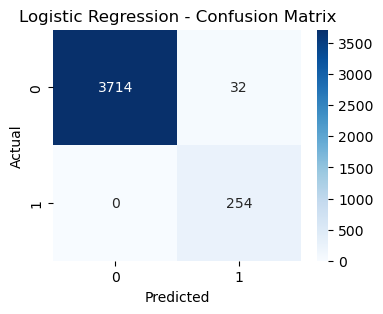

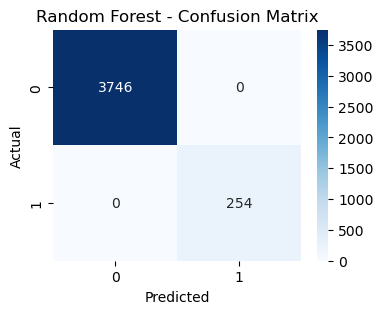

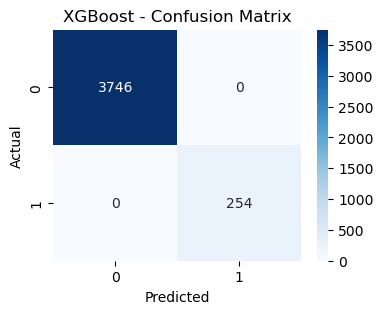

In [40]:
# ==========================================================
# Step 12: Confusion Matrices
# ==========================================================
models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [41]:
# ==========================================================
# Step 13: Save Predictions
# ==========================================================
df['Predicted_Dropout_RF'] = rf_model.predict(X)
df[['Patient_ID', 'Predicted_Dropout_RF']].to_csv("dropout_predictions.csv", index=False)
print("\n✅ Dropout predictions saved to dropout_predictions.csv")


✅ Dropout predictions saved to dropout_predictions.csv
